## Attention

It is widely agreed that a good starting point for a sequence-to-sequence model is a recurrent neural network and attention. In this post we'll look at applying attention to our current models.

This [Github repository](https://github.com/philipperemy/keras-attention-mechanism) by Philippe Rémy contains a great walk through for applying attention in Keras.

<img src=https://raw.githubusercontent.com/philipperemy/keras-attention-mechanism/master/assets/graph_multi_attention.png width="500">

Attention, as applied by Philippe, is fairly straightforward to implement in Keras. 

The process is as follows:

* An input is provided in with the dimensions: BS (batch_size), TS (time_steps), and I (input_dimension). I represents the length of each time step, e.g. if we had a one-hot vector with a length equal to a vocabulary size of 2500, I would be 2500. Time steps are the same as our sequence elements, e.g. if a sequence has a length of 22, time steps = 22. Batch size is the size used to group samples, e.g. for training.
* This is followed by a [Permute](https://keras.io/layers/core/#permute) operation. This swaps around the first and second dimensions (excluding the batch size I think). So you have (batch_size, input_dim, time_steps). For example, if we had (None, 22, 2500) this would be swapped to (None, 2500, 22). 
* As stated in the code the Reshape line is just for housekeeping - the array is aleady switched to being input_dim, time_steps.
* We then generate a dense layer, which is just a matrix multiplication with an output of size TS. This gives us a vector the same size as the number of our timesteps. Softmax is applied on the output to normalise as a probability (e.g. values are from 0-1 and sum to 1).
* If a single attention vector is required the mean over all dimensions is taken - a single dimension vector may be useful as a simplification when visualising.
* Some more housekeeping is then performed to again switch around the first and second dimensions (i.e. switch back to the original form).
* Finally we perform a matrix multiplication using our obtained attention vector (a_probs) on the inputs. We then output the result of the multiplication, which is the application of the attention.

Our attention weights are thus stored as parameters of the Dense layer.

The attention weights can be applied before or after our recurrent neural network (in our initial models an LSTM). When applying our weights after the LSTM we need to flatten the output to get a vector.

### Loading our Data (Again)

In [1]:
import pickle
import os

PIK = "claim_and_title.data"

if not os.path.isfile(PIK):
    # Download file
    !wget https://benhoyle.github.io/notebooks/title_generation/claim_and_title.data

with open(PIK, "rb") as f:
    print("Loading data")
    data = pickle.load(f)
    print("{0} samples loaded".format(len(data)))
    
print("\n\nAdding start and stop tokens to output")
data = [(c, "startseq {0} stopseq".format(t)) for c, t in data]
                                      
print("\n\nAn example title:", data[0][1])
print("----")
print("An example claim:", data[0][0])

Loading data
30000 samples loaded


Adding start and stop tokens to output


An example title: startseq System and method for session restoration at geo-redundant gateways stopseq
----
An example claim: 
1. A method for managing a backup service gateway (SGW) associated with a primary SGW, the method comprising:
periodically receiving from the primary SGW at least a portion of corresponding UE session state information, the received portion of session state information being sufficient to enable the backup SGW to indicate to an inquiring management entity that UEs having an active session supported by the primary SGW are in a live state; and
in response to a failure of the primary SGW, the backup SGW assuming management of IP addresses and paths associated with said primary SGW and transmitting a Downlink Data Notification (DDN) toward a Mobility Management Entity (MME) for each of said UEs having an active session supported by the failed primary SGW to detach from the network and reat

### Applying to Ludwig Model with Shared Embedding

Our best version of the Ludwig model is the version with shared Glove embeddings. We will apply our attention mechanism to this after the application of the LSTMs. This effectively weights the ?. We'll create a new class and overwrite the build_model method. 

We need to remember to amend the definition of the LSTM such that sequences are returned. This then enables the correct dimensionality of input for our attention layer. 

This [post](https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/) explains the general functioning of the LSTM cell in Keras and the return of sequences and hidden states.

This [post](https://medium.com/datalogue/attention-in-keras-1892773a4f22) explains attention.

Some things to note:

* Some posts and text books refer to the output of an LSTM as `y`, others as `h`. The hidden state is also sometimes referred to as `h` (e.g. when used with `y`) and at other times `c` (e.g. with `h`). 

In [2]:
from ludwig_model import LudwigModel

Using TensorFlow backend.


## How this Attention Mechanism Works

Let's start by considering one sample. We can effectively ignore the first batch size (BS) dimension (0) in our code.

The attention mechanism set out above starts with an input from an encoding LSTM. As return sequences is true, the encoding LSTM outputs an array of length time steps (TS), where each time step has an associated encoding vector (I or h). In our case, we have an LSTM with a latent dimension of 128, which outputs encoding vectors of length 128 for each time step. Our Keras LSTM output for each sample is thus a matrix of size (300, 128), i.e. 300 timesteps each having a vector of length 128.

A normal Dense layer takes an input vector and maps it to an output vector, e.g. X > Y where X is length L1 and Y is length L2. If we pass a matrix to a Dense layer, e.g. 500 samples of X - of size (500, L1) we would get a matrix of (500, L2) out. This is the same if we are doing things in batches - then dense layer is still applied to the last dimension (e.g. still L1>L2 even if we had batches of 64, e.g. input - (64, 500, L1).

When we permute, we swap around our sample. So we have a sample that is the timestep data for each feature (e.g. as how each hidden dimension changes over the timesteps). E.g. `[ft1, ft2, ft3 ... fT]` where T = 22. The output of the dense layer is a (pseudo-) probability across the 22 time steps. I.e. a weighting for each time step for the feature. This is repeated for each feature so we have F_1=`[w1, w2, ... wT]`, F_2=..., F_latent_dim = `[...]` - i.e. 128 features with weights for 22 time steps (128, 22). We then swap the matrix around again, so our weights are arranged in timestep order, e.g. T_1=`[w_f1, w_f2, ..., w_f_latent_dim]` where each column / vector will sum to 1. This gives us a matrix of (22, 128).

The later Mulitply operation multiplies these weights against the original LSTM encoding.

In descriptions of attention we have a context vector that, for a output timestamp, is the weighted sum of the attention weights and the original encoding. Each encoding (h) has a weight (a).

Our issue is that the output of our Multiply operation is a matrix of (128, 22) (as we are applying weights to each individual dimension of the encoding). We need to reduce this down to a vector. The matrix has weighted terms for each latent dimension and each timestamp. We could simplify this by only having one weight term per timestamp in the earlier calculations. ***Or to sum our weights across the time dimensions.*** For this can I just use K.sum on the backend?



In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 501208492602435367
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2075394048
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7556445906835092009
physical_device_desc: "device: 0, name: GeForce GTX 1060 3GB, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


In [4]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding, concatenate, merge, Permute, Reshape, \
Flatten, multiply, AveragePooling1D, RepeatVector, Lambda
from keras import backend as K

class LWAtt(LudwigModel):
    """ Version of our Ludwig model with attention."""
    
    def _build_model(self):
        """ Build the model. """
        print("Building model")
        self._load_shared_embedding()
        # Define inputs
        inputs_encoder = Input(shape=(self.encoder_seq_length,))
        inputs_decoder = Input(shape=(self.decoder_seq_length,))
        
        # Define Shared Embedding Layer
        Shared_Embedding = Embedding(
            output_dim=self.word_embedding_size,
            input_dim=self.num_encoder_tokens,
            weights=[self.embedding_matrix]   
        )
        # Ah our problem is that our shared embedding has encoder length but we are also using on decoder
        
        embedded_inputs_encoder = Shared_Embedding(inputs_encoder)
        embedded_inputs_decoder = Shared_Embedding(inputs_decoder)
        
        # Define LSTMs - these return output state h for each timestep (as we have r_s=True)
        encoder_LSTM = LSTM(self.latent_dim, return_sequences=True)
        decoder_LSTM = LSTM(self.latent_dim, return_sequences=True)
        
        # So output of this is, e.g. BS, 300, 128, i.e. an h vector for each TS
        encoder_context = encoder_LSTM(embedded_inputs_encoder)
        
        # Add attention to encoder encodings - here we are swapping the dims to BS, 128, 300
        a = Permute((2, 1))(encoder_context)
        #a = Reshape((self.latent_dim, self.encoder_seq_length))(a) # this line is not useful. It's just to know which dimension is what.
        # Here we apply a dense layer to each a matrix
        a = Dense(self.encoder_seq_length, activation='softmax', use_bias=False)(a)
        # Single attention vector
        # a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        # a = RepeatVector(self.latent_dim)(a)
        a_probs = Permute((2, 1), name='attention_vec_a')(a)
        att_mul_1 = multiply([encoder_context, a_probs])
        
        # Sum over time dimension
        att_mul_1 = Lambda(lambda x: K.sum(x, axis=1), name="sum_over_time_att_1")(att_mul_1)
        # Take the average over our 300 time steps and flatten to 1D
        #flatt_mul_1 = Flatten()(AveragePooling1D(pool_size=self.encoder_seq_length, strides=None, padding='valid')(att_mul_1))
        # summary input model
        decoder_context = decoder_LSTM(embedded_inputs_decoder)
         # Add attention to answer encodings
        b = Permute((2, 1))(decoder_context)
        #b = Reshape((self.latent_dim, self.decoder_seq_length))(b) # this line is not useful. It's just to know which dimension is what.
        b = Dense(self.decoder_seq_length, activation='softmax')(b)
        # Single attention vector
        # b = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(b)
        print(b.shape) # - the above is of shape ?, 22
        #b = RepeatVector(self.latent_dim)(b) # This repeats the averaged vector across the latent dim to create a matrix of 128,22
        b_probs = Permute((2, 1), name='attention_vec_b')(b)
        att_mul_2 = multiply([decoder_context, b_probs])
        att_mul_2 = Lambda(lambda x: K.sum(x, axis=1), name="sum_over_time_att_2")(att_mul_2)
        # Take the average over our 22 time steps and flatten to 1D
        #flatt_mul_2 = Flatten()(AveragePooling1D(pool_size=self.decoder_seq_length, strides=None, padding='valid')(att_mul_2))
        # Now flatten our attention matrices to get a vector for both sequences
        # att_mul_1 = Flatten()(att_mul_1)
        # att_mul_2 = Flatten()(att_mul_2)
        # decoder output model
        decoder1 = concatenate([att_mul_1, att_mul_2], axis=1)
        # decoder1 = concatenate([att_mul_1, att_mul_2])
        # We do need to flatten our concatenated array to a vector here
        # We can either use flatten(), which gives high dimensionality
        # Or use an average in the time dimension
        #cat_dim = self.encoder_seq_length + self.decoder_seq_length
        
        #flattened = AveragePooling1D(pool_size=cat_dim, strides=None, padding='valid')(decoder1)
        outputs = Dense(self.num_decoder_tokens, activation='softmax')(decoder1)
        # tie it together [article, summary] [word]
        self.model = Model(inputs=[inputs_encoder, inputs_decoder], outputs=outputs)
        self.infdec = self.model
        print("Compiling model")
        self.model.compile(loss='categorical_crossentropy', optimizer='adam')

In [6]:
machine = LWAtt(
    encoder_texts=[d[0] for d in data],
    decoder_texts=[d[1] for d in data],
    encoder_seq_length=300,
    decoder_seq_length=22,
    num_encoder_tokens=2500,
    num_decoder_tokens=2500,
    latent_dim=128,
    weights_file="class_LWattmodel_sin_att.hdf5",
    training_set_size=250
)

Fitting tokenizers
Our input data has shape (30000, 300) and our output data has shape (30000, 22)
Generating training and test data
Building model
Loading GloVe 100d embeddings from file
Found 400000 word vectors.
Building embedding matrix
(?, 128, 22)
Compiling model
No existing weights found


In [7]:
machine.print()

Training Model:

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 22)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         multiple             250000      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 300, 128)     117248      embedding_1[0][0]          

We have the same number of parameters. However, this time our 128 LSTM outputs have been subject to the attention weighting.

cf:
```
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
==================================================================================================
input_1 (InputLayer)            (None, 300)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 22)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 300, 100)     250000      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 128)          117248      embedding_1[0][0]                
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 128)          117248      embedding_1[1][0]                
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 256)          0           lstm_1[0][0]                     
                                                                 lstm_2[0][0]                     
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 2500)         642500      concatenate_1[0][0]              
==================================================================================================
Total params: 1,126,996
Trainable params: 1,126,996
Non-trainable params: 0
__________________________________________________________________________________________________
None
```

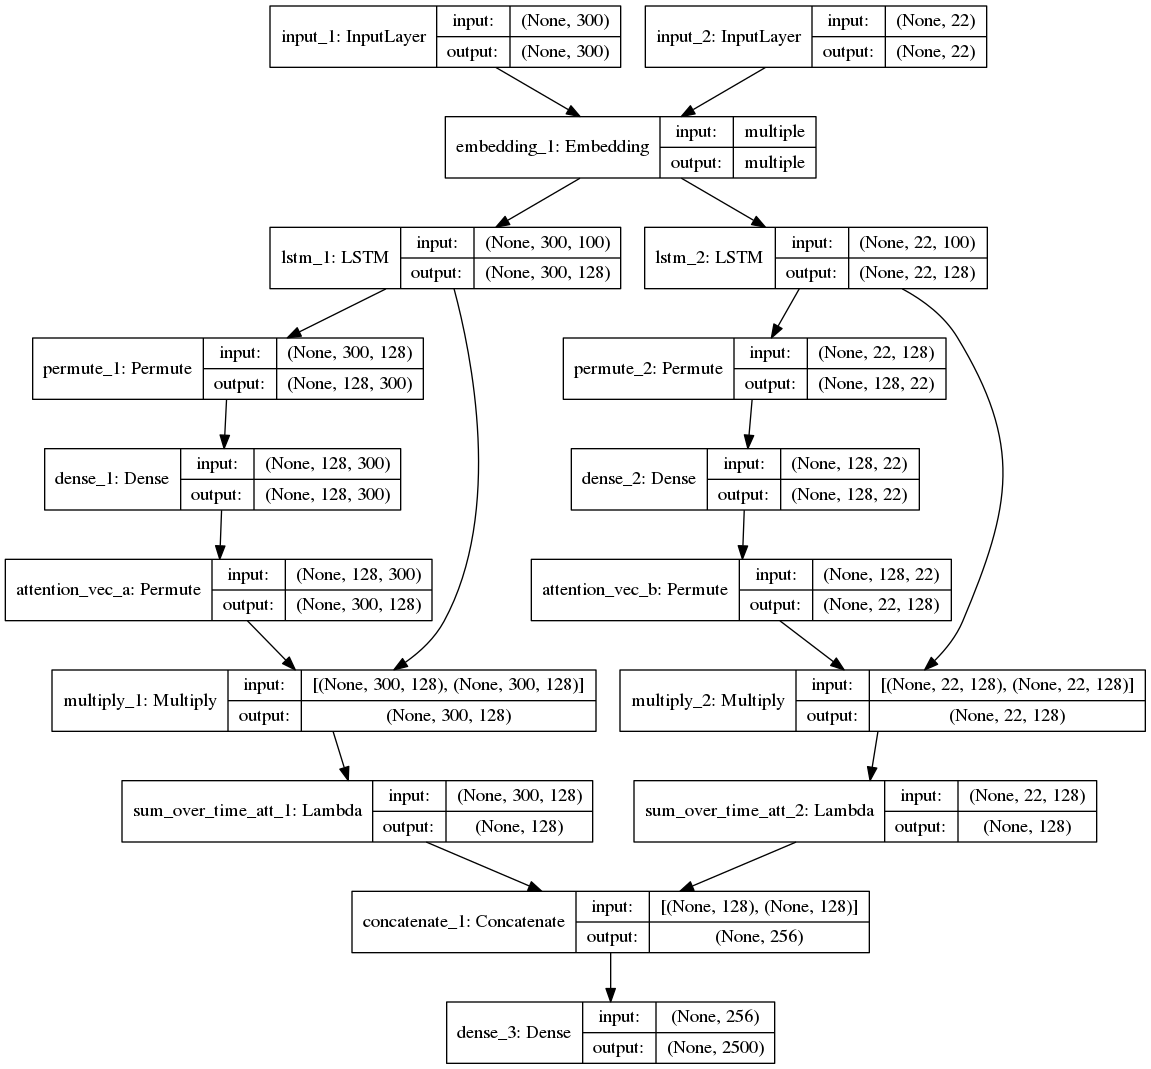

In [8]:
from keras.utils.vis_utils import model_to_dot
from IPython.display import Image
Image(model_to_dot(machine.model, show_shapes=True).create_png(prog='dot'))

In [9]:
machine.train(epochs=2)

Training for epoch 0
Training on batch 0 to 250 of 24000
Train on 2639 samples, validate on 655 samples
Epoch 1/1
2639/2639 [==============================] - 90s 34ms/step - loss: 3.7594 - val_loss: 3.4036
Training on batch 250 to 500 of 24000
Train on 2484 samples, validate on 658 samples
Epoch 1/1
2484/2484 [==============================] - 95s 38ms/step - loss: 3.3319 - val_loss: 3.2739
Training on batch 500 to 750 of 24000
Train on 2586 samples, validate on 583 samples
Epoch 1/1
2586/2586 [==============================] - 102s 40ms/step - loss: 3.3952 - val_loss: 3.3979
Training on batch 750 to 1000 of 24000
Train on 2613 samples, validate on 667 samples
Epoch 1/1
2613/2613 [==============================] - 100s 38ms/step - loss: 3.3392 - val_loss: 3.1102
Training on batch 1000 to 1250 of 24000
Train on 2532 samples, validate on 687 samples
Epoch 1/1
2532/2532 [==============================] - 85s 34ms/step - loss: 3.2981 - val_loss: 3.5525
Training on batch 1250 to 1500 of 24

2465/2465 [==============================] - 81s 33ms/step - loss: 2.7261 - val_loss: 2.8200
Training on batch 11000 to 11250 of 24000
Train on 2399 samples, validate on 669 samples
Epoch 1/1
2399/2399 [==============================] - 79s 33ms/step - loss: 2.6303 - val_loss: 2.7953
Training on batch 11250 to 11500 of 24000
Train on 2476 samples, validate on 669 samples
Epoch 1/1
2476/2476 [==============================] - 99s 40ms/step - loss: 2.7336 - val_loss: 2.6720
Training on batch 11500 to 11750 of 24000
Train on 2450 samples, validate on 648 samples
Epoch 1/1
2450/2450 [==============================] - 90s 37ms/step - loss: 2.5874 - val_loss: 2.7919
Training on batch 11750 to 12000 of 24000
Train on 2553 samples, validate on 646 samples
Epoch 1/1
2553/2553 [==============================] - 96s 37ms/step - loss: 2.6911 - val_loss: 2.6048
Training on batch 12000 to 12250 of 24000
Train on 2395 samples, validate on 595 samples
Epoch 1/1
2395/2395 [=============================

2534/2534 [==============================] - 85s 34ms/step - loss: 2.5233 - val_loss: 2.5448
Training on batch 21750 to 22000 of 24000
Train on 2515 samples, validate on 693 samples
Epoch 1/1
2515/2515 [==============================] - 82s 33ms/step - loss: 2.6358 - val_loss: 2.7682
Training on batch 22000 to 22250 of 24000
Train on 2586 samples, validate on 627 samples
Epoch 1/1
2586/2586 [==============================] - 84s 32ms/step - loss: 2.3574 - val_loss: 2.4984
Training on batch 22250 to 22500 of 24000
Train on 2543 samples, validate on 676 samples
Epoch 1/1
2543/2543 [==============================] - 84s 33ms/step - loss: 2.5074 - val_loss: 2.7229
Training on batch 22500 to 22750 of 24000
Train on 2487 samples, validate on 582 samples
Epoch 1/1
2487/2487 [==============================] - 81s 32ms/step - loss: 2.5872 - val_loss: 2.4007
Training on batch 22750 to 23000 of 24000
Train on 2557 samples, validate on 610 samples
Epoch 1/1
2557/2557 [=============================

ImportError: `save_weights` requires h5py.

In [15]:
machine.example_output(5)

------------------------------------------
Sample of claim text: 1 an image encoding system including one or more processing devices comprising an being at least one of the one or more processing devices configured to perform prediction on a current block included 

Predicted title is: image processing apparatus and method for controlling the same  
Actual title is: random access image encoding system and method  
---
Sample of claim text: 1 a method of and data transfer between a controller device and a target device using a control signal comprising the transfer of a data word over a data bus from the target device to the controller d

Predicted title is: method and apparatus for controlling a memory device  
Actual title is: method for transferring address information  
---
Sample of claim text: coupled to the host computer wherein each of the first storage system and the second storage system comprises a plurality of storage devices configuring a plurality of raid redundant array o

### Comments on Training

The training and test loss start to diverge around 250 iterations. Then the model starts overfitting on the training data. We could probably do with some regularisation to prevent overfitting and keep the test loss in sync with the training loss.

We also need to set up the save weights so it only saves in the test loss has not increased by a margin.

Let's try with some regularisation using Dropout and L2 regularizer.

In [22]:
from keras.regularizers import l2 # L2-regularisation
l2_lambda = 0.01

class LWAtt_reg(LudwigModel):
    """ Version of our Ludwig model with attention."""
    
    def _build_model(self):
        """ Build the model. """
        print("Building model")
        self._load_shared_embedding()
        # Define inputs
        inputs_encoder = Input(shape=(self.encoder_seq_length,))
        inputs_decoder = Input(shape=(self.decoder_seq_length,))
        
        # Define Shared Embedding Layer
        Shared_Embedding = Embedding(
            output_dim=self.word_embedding_size,
            input_dim=self.num_encoder_tokens,
            weights=[self.embedding_matrix]   
        )
        # Ah our problem is that our shared embedding has encoder length but we are also using on decoder
        
        embedded_inputs_encoder = Shared_Embedding(inputs_encoder)
        embedded_inputs_decoder = Shared_Embedding(inputs_decoder)
        
        # Define LSTMs - these return output state h for each timestep (as we have r_s=True)
        encoder_LSTM = LSTM(self.latent_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)
        decoder_LSTM = LSTM(self.latent_dim, return_sequences=True,  dropout=0.2, recurrent_dropout=0.2)
        
        # So output of this is, e.g. BS, 300, 128, i.e. an h vector for each TS
        encoder_context = encoder_LSTM(embedded_inputs_encoder)
        
        # Add attention to encoder encodings - here we are swapping the dims to BS, 128, 300
        a = Permute((2, 1))(encoder_context)

        a = Dense(self.encoder_seq_length, activation='softmax', use_bias=False, kernel_regularizer=l2(l2_lambda))(a)

        a_probs = Permute((2, 1), name='attention_vec_a')(a)
        att_mul_1 = multiply([encoder_context, a_probs])

        # Sum over time dimension
        att_mul_1 = Lambda(lambda x: K.sum(x, axis=1), name="sum_over_time_att_1")(att_mul_1)

        decoder_context = decoder_LSTM(embedded_inputs_decoder)
         # Add attention to answer encodings
        b = Permute((2, 1))(decoder_context)
        b = Dense(self.decoder_seq_length, activation='softmax', use_bias=False, kernel_regularizer=l2(l2_lambda))(b)
       
        b_probs = Permute((2, 1), name='attention_vec_b')(b)
        att_mul_2 = multiply([decoder_context, b_probs])
        att_mul_2 = Lambda(lambda x: K.sum(x, axis=1), name="sum_over_time_att_2")(att_mul_2)
        
        decoder1 = concatenate([att_mul_1, att_mul_2], axis=1)
        
        outputs = Dense(self.num_decoder_tokens, activation='softmax', kernel_regularizer=l2(l2_lambda))(decoder1)
        # tie it together [article, summary] [word]
        self.model = Model(inputs=[inputs_encoder, inputs_decoder], outputs=outputs)
        self.infdec = self.model
        print("Compiling model")
        self.model.compile(loss='categorical_crossentropy', optimizer='adam')

In [23]:
reg_machine = LWAtt_reg(
    encoder_texts=[d[0] for d in data],
    decoder_texts=[d[1] for d in data],
    encoder_seq_length=300,
    decoder_seq_length=22,
    num_encoder_tokens=2500,
    num_decoder_tokens=2500,
    latent_dim=128,
    weights_file="class_LWattmodel_att_reg.hdf5",
    training_set_size=250
)

Fitting tokenizers
Our input data has shape (30000, 300) and our output data has shape (30000, 22)
Generating training and test data
Building model
Loading GloVe 100d embeddings from file
Found 400000 word vectors.
Building embedding matrix
Compiling model
No existing weights found


Training for epoch 0
Training on batch 0 to 250 of 24000
Train on 2639 samples, validate on 655 samples
Epoch 1/1
2639/2639 [==============================] - 41s 16ms/step - loss: 5.8585 - val_loss: 3.7435
Training on batch 250 to 500 of 24000
Train on 2484 samples, validate on 658 samples
Epoch 1/1
2484/2484 [==============================] - 39s 16ms/step - loss: 3.5613 - val_loss: 3.4640
Training on batch 500 to 750 of 24000
Train on 2586 samples, validate on 583 samples
Epoch 1/1
2586/2586 [==============================] - 42s 16ms/step - loss: 3.5851 - val_loss: 3.6235
Training on batch 750 to 1000 of 24000
Train on 2613 samples, validate on 667 samples
Epoch 1/1
2613/2613 [==============================] - 42s 16ms/step - loss: 3.5451 - val_loss: 3.3144
Training on batch 1000 to 1250 of 24000
Train on 2532 samples, validate on 687 samples
Epoch 1/1
2532/2532 [==============================] - 42s 17ms/step - loss: 3.4953 - val_loss: 3.7243
Training on batch 1250 to 1500 of 2400

2465/2465 [==============================] - 40s 16ms/step - loss: 3.3000 - val_loss: 3.2565
Training on batch 11000 to 11250 of 24000
Train on 2399 samples, validate on 669 samples
Epoch 1/1
2399/2399 [==============================] - 38s 16ms/step - loss: 3.1821 - val_loss: 3.2911
Training on batch 11250 to 11500 of 24000
Train on 2476 samples, validate on 669 samples
Epoch 1/1
2476/2476 [==============================] - 39s 16ms/step - loss: 3.2758 - val_loss: 3.2011
Training on batch 11500 to 11750 of 24000
Train on 2450 samples, validate on 648 samples
Epoch 1/1
2450/2450 [==============================] - 39s 16ms/step - loss: 3.1438 - val_loss: 3.2925
Training on batch 11750 to 12000 of 24000
Train on 2553 samples, validate on 646 samples
Epoch 1/1
2553/2553 [==============================] - 41s 16ms/step - loss: 3.2567 - val_loss: 3.1641
Training on batch 12000 to 12250 of 24000
Train on 2395 samples, validate on 595 samples
Epoch 1/1
2395/2395 [=============================

2534/2534 [==============================] - 40s 16ms/step - loss: 3.1306 - val_loss: 3.0925
Training on batch 21750 to 22000 of 24000
Train on 2515 samples, validate on 693 samples
Epoch 1/1
2515/2515 [==============================] - 40s 16ms/step - loss: 3.2643 - val_loss: 3.4264
Training on batch 22000 to 22250 of 24000
Train on 2586 samples, validate on 627 samples
Epoch 1/1
2586/2586 [==============================] - 41s 16ms/step - loss: 3.0234 - val_loss: 3.0887
Training on batch 22250 to 22500 of 24000
Train on 2543 samples, validate on 676 samples
Epoch 1/1
2543/2543 [==============================] - 42s 16ms/step - loss: 3.1706 - val_loss: 3.3364
Training on batch 22500 to 22750 of 24000
Train on 2487 samples, validate on 582 samples
Epoch 1/1
2487/2487 [==============================] - 40s 16ms/step - loss: 3.2226 - val_loss: 3.1001
Training on batch 22750 to 23000 of 24000
Train on 2557 samples, validate on 610 samples
Epoch 1/1
2557/2557 [=============================

Training on batch 6000 to 6250 of 24000
Train on 2531 samples, validate on 637 samples
Epoch 1/1
2531/2531 [==============================] - 40s 16ms/step - loss: 3.0886 - val_loss: 3.1539
Training on batch 6250 to 6500 of 24000
Train on 2574 samples, validate on 602 samples
Epoch 1/1
2574/2574 [==============================] - 41s 16ms/step - loss: 3.2480 - val_loss: 3.1027
Training on batch 6500 to 6750 of 24000
Train on 2479 samples, validate on 602 samples
Epoch 1/1
2479/2479 [==============================] - 39s 16ms/step - loss: 3.2251 - val_loss: 3.2005
Training on batch 6750 to 7000 of 24000
Train on 2548 samples, validate on 625 samples
Epoch 1/1
2548/2548 [==============================] - 41s 16ms/step - loss: 3.2138 - val_loss: 3.2061
Training on batch 7000 to 7250 of 24000
Train on 2603 samples, validate on 671 samples
Epoch 1/1
2603/2603 [==============================] - 42s 16ms/step - loss: 3.2048 - val_loss: 3.3016
Training on batch 7250 to 7500 of 24000
Train on 2

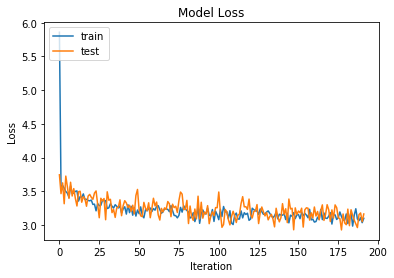

In [24]:
reg_machine.train(epochs=2)

In [ ]:
reg_machine.train(epochs=5)

Training for epoch 0
Training on batch 0 to 250 of 24000
Train on 2639 samples, validate on 655 samples
Epoch 1/1
2639/2639 [==============================] - 40s 15ms/step - loss: 3.1682 - val_loss: 3.0517
Training on batch 250 to 500 of 24000
Train on 2484 samples, validate on 658 samples
Epoch 1/1
2484/2484 [==============================] - 37s 15ms/step - loss: 2.9829 - val_loss: 3.1555
Training on batch 500 to 750 of 24000
Train on 2586 samples, validate on 583 samples
Epoch 1/1
2586/2586 [==============================] - 40s 16ms/step - loss: 3.1525 - val_loss: 3.3748
Training on batch 750 to 1000 of 24000
Train on 2613 samples, validate on 667 samples
Epoch 1/1
2613/2613 [==============================] - 42s 16ms/step - loss: 3.0892 - val_loss: 3.1288
Training on batch 1000 to 1250 of 24000
Train on 2532 samples, validate on 687 samples
Epoch 1/1
2532/2532 [==============================] - 40s 16ms/step - loss: 2.9887 - val_loss: 3.4371
Training on batch 1250 to 1500 of 2400

### Comments on Dropout & Regularisation

Interesting. 

While adding Dropout and regularisation appears to keep the training and test loss in sync, the model seems to struggle more to find a optima - the loss is higher and the model appears to find a pattern and stick to it (trapped in local minima?).